In [19]:
import matplotlib.pyplot as plt
import numpy as np
import dsdl
import numpy.random
from typing import Callable, List
import pandas as pd
import json
import os

%load_ext autoreload
%autoreload 2
from regression.reg import LossType

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Logistic regression

In [20]:
from optimizers.Optimizer import Optimizer

In [27]:
DATA_DIR = 'data/'

def get_data(dataset_filename: str):
    """
    Loads dataset from csv file. The last column must represent the target variable.
    :param dataset_filename: Filename of the dataset from dsdl module.
    :return: (X, y) feature and target data.
    """
    filepath = os.path.join(DATA_DIR, dataset_filename)
    df = pd.read_csv(filepath)
    return df.iloc[:,:-1].values, df.iloc[:,-1].values.reshape(-1, 1)

def build_model(X, y):
    """
    Joins weights
    :param X: shape=(N, D). Train data
    :param y: shape=(N, 1). Target data
    :return: shape=(N, D+1). Built model for logistic regression.
    """
    return np.c_[np.zeros((y.shape[0], 1)), X]

def get_initial_weights(tx):
    """
    Returns weights initialized from the uniform distribution [0, 1].
    :param tx: shape=(N, D). Build model
    :return: shape=(D, 1) Initial weights
    """
    np.random.seed(2022)
    return np.zeros(shape=(tx.shape[1], 1))

def test_method(method: Optimizer,
                initial_weights,
                tx,
                y,
                max_iter: int,
                loss_type,
                *parameter):
        """
        :param method: Optimization method implementation from src optimizers module.
        :param dataset_name: Name of the dataset from dsdl module.
        :param max_iter: Number of iterations to test.
        :param parameters optional: Dataclass containing parameters used int optimization method.
        :return: List of gradients from optimization method.
        """
        gradients, loss = method.optimize(initial_weights, tx, y, max_iter, loss_type)
        return [np.linalg.norm(grad, 2) for grad in gradients], loss

In [28]:
from optimizers.SGD import SGD
from optimizers.AdaGrad import AdaGrad
from optimizers.RMSProp import RMSProp

In [35]:
DATASETS = ['diabetes.csv', 'housing.csv']
LOSS_TYPES = [LossType.MAE, LossType.MSE]

METHODS = [
    AdaGrad(lambda_=0.0001, epsilon= 0.0001),
    SGD(lambda_=0.0001),
    RMSProp(lambda_=0.0001, decay_rate_=0.9, epsilon=0.0001)
]

1. Przeprowadzić testy lambda [0.0001, 0.001, 0.01]
2. Wybrać najlepszy parametr lambda i przeprowadzić testy decay_rate_

## Run simulations

In [ ]:
ITERATIONS = 1000000
N_RUNS = 1

all_gradients = []

datasets_data = {}
for i, dataset_name in enumerate(DATASETS):

    print("Dataset", dataset_name)

    X, y = get_data(dataset_name)
    tx = build_model(X, y)
    initial_weights = get_initial_weights(tx)

    methods_data = {}
    for method in METHODS:
        for loss_type in LOSS_TYPES:
            print("Method: ", method.name, ", loss: ", loss_type)

            gradients_5_runs = list()
            losses_5_runs = list()
            for _ in range(N_RUNS):
                gradients, losses = test_method(method, initial_weights, tx, y, ITERATIONS, loss_type)
                # save gradients and losses
                gradients_5_runs.append(gradients)
                losses_5_runs.append(losses)

            # calculate mean of gradients and loses
            gradients_mean = np.mean(gradients_5_runs, axis=0)
            gradients_stddev = np.std(gradients_5_runs, axis=0)
            gradients_lower = gradients_mean - gradients_stddev
            gradients_upper = gradients_mean + gradients_stddev

            # calculate mean of gradients and loses
            losses_mean = np.mean(losses_5_runs, axis=0)
            losses_stddev = np.std(losses_5_runs, axis=0)
            losses_lower = losses_mean - losses_stddev
            losses_upper = losses_mean + losses_stddev

            methods_data[method.name] = {
                "gradient_mean": list(gradients_mean),
                "gradient_lower": list(gradients_lower),
                "gradient_upper": list(gradients_upper),
                "losses_mean": list(losses_mean),
                "losses_lower": list(losses_lower),
                "losses_upper": list(losses_upper),
                "n_runs": N_RUNS,
                "n_iterations": ITERATIONS
            }
            datasets_data[dataset_name] = methods_data

Dataset diabetes.csv
Method:  AdaGrad , loss:  LossType.MAE
0
50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000
650000
700000
750000
800000
850000
900000
950000
Method:  AdaGrad , loss:  LossType.MSE
0
50000
100000
150000
200000
250000
300000


In [48]:
methods_colors = {
    "SGD": "blue",
    "AdaGrad": "purple",
    "RMSProp": "orange"
}

In [55]:
datasets_data.keys()

dict_keys(['diabetes.csv', 'housing.csv'])

In [56]:
datasets_data['diabetes.csv'].keys()

dict_keys(['AdaGrad', 'SGD', 'RMSProp'])

In [58]:
datasets_data['diabetes.csv']['AdaGrad'].keys()

dict_keys(['gradient_mean', 'gradient_lower', 'gradient_upper', 'losses_mean', 'losses_lower', 'losses_upper', 'n_runs', 'n_iterations'])

### Plot gradients

Dataset diabetes.csv
Method AdaGrad
Method SGD
Method RMSProp


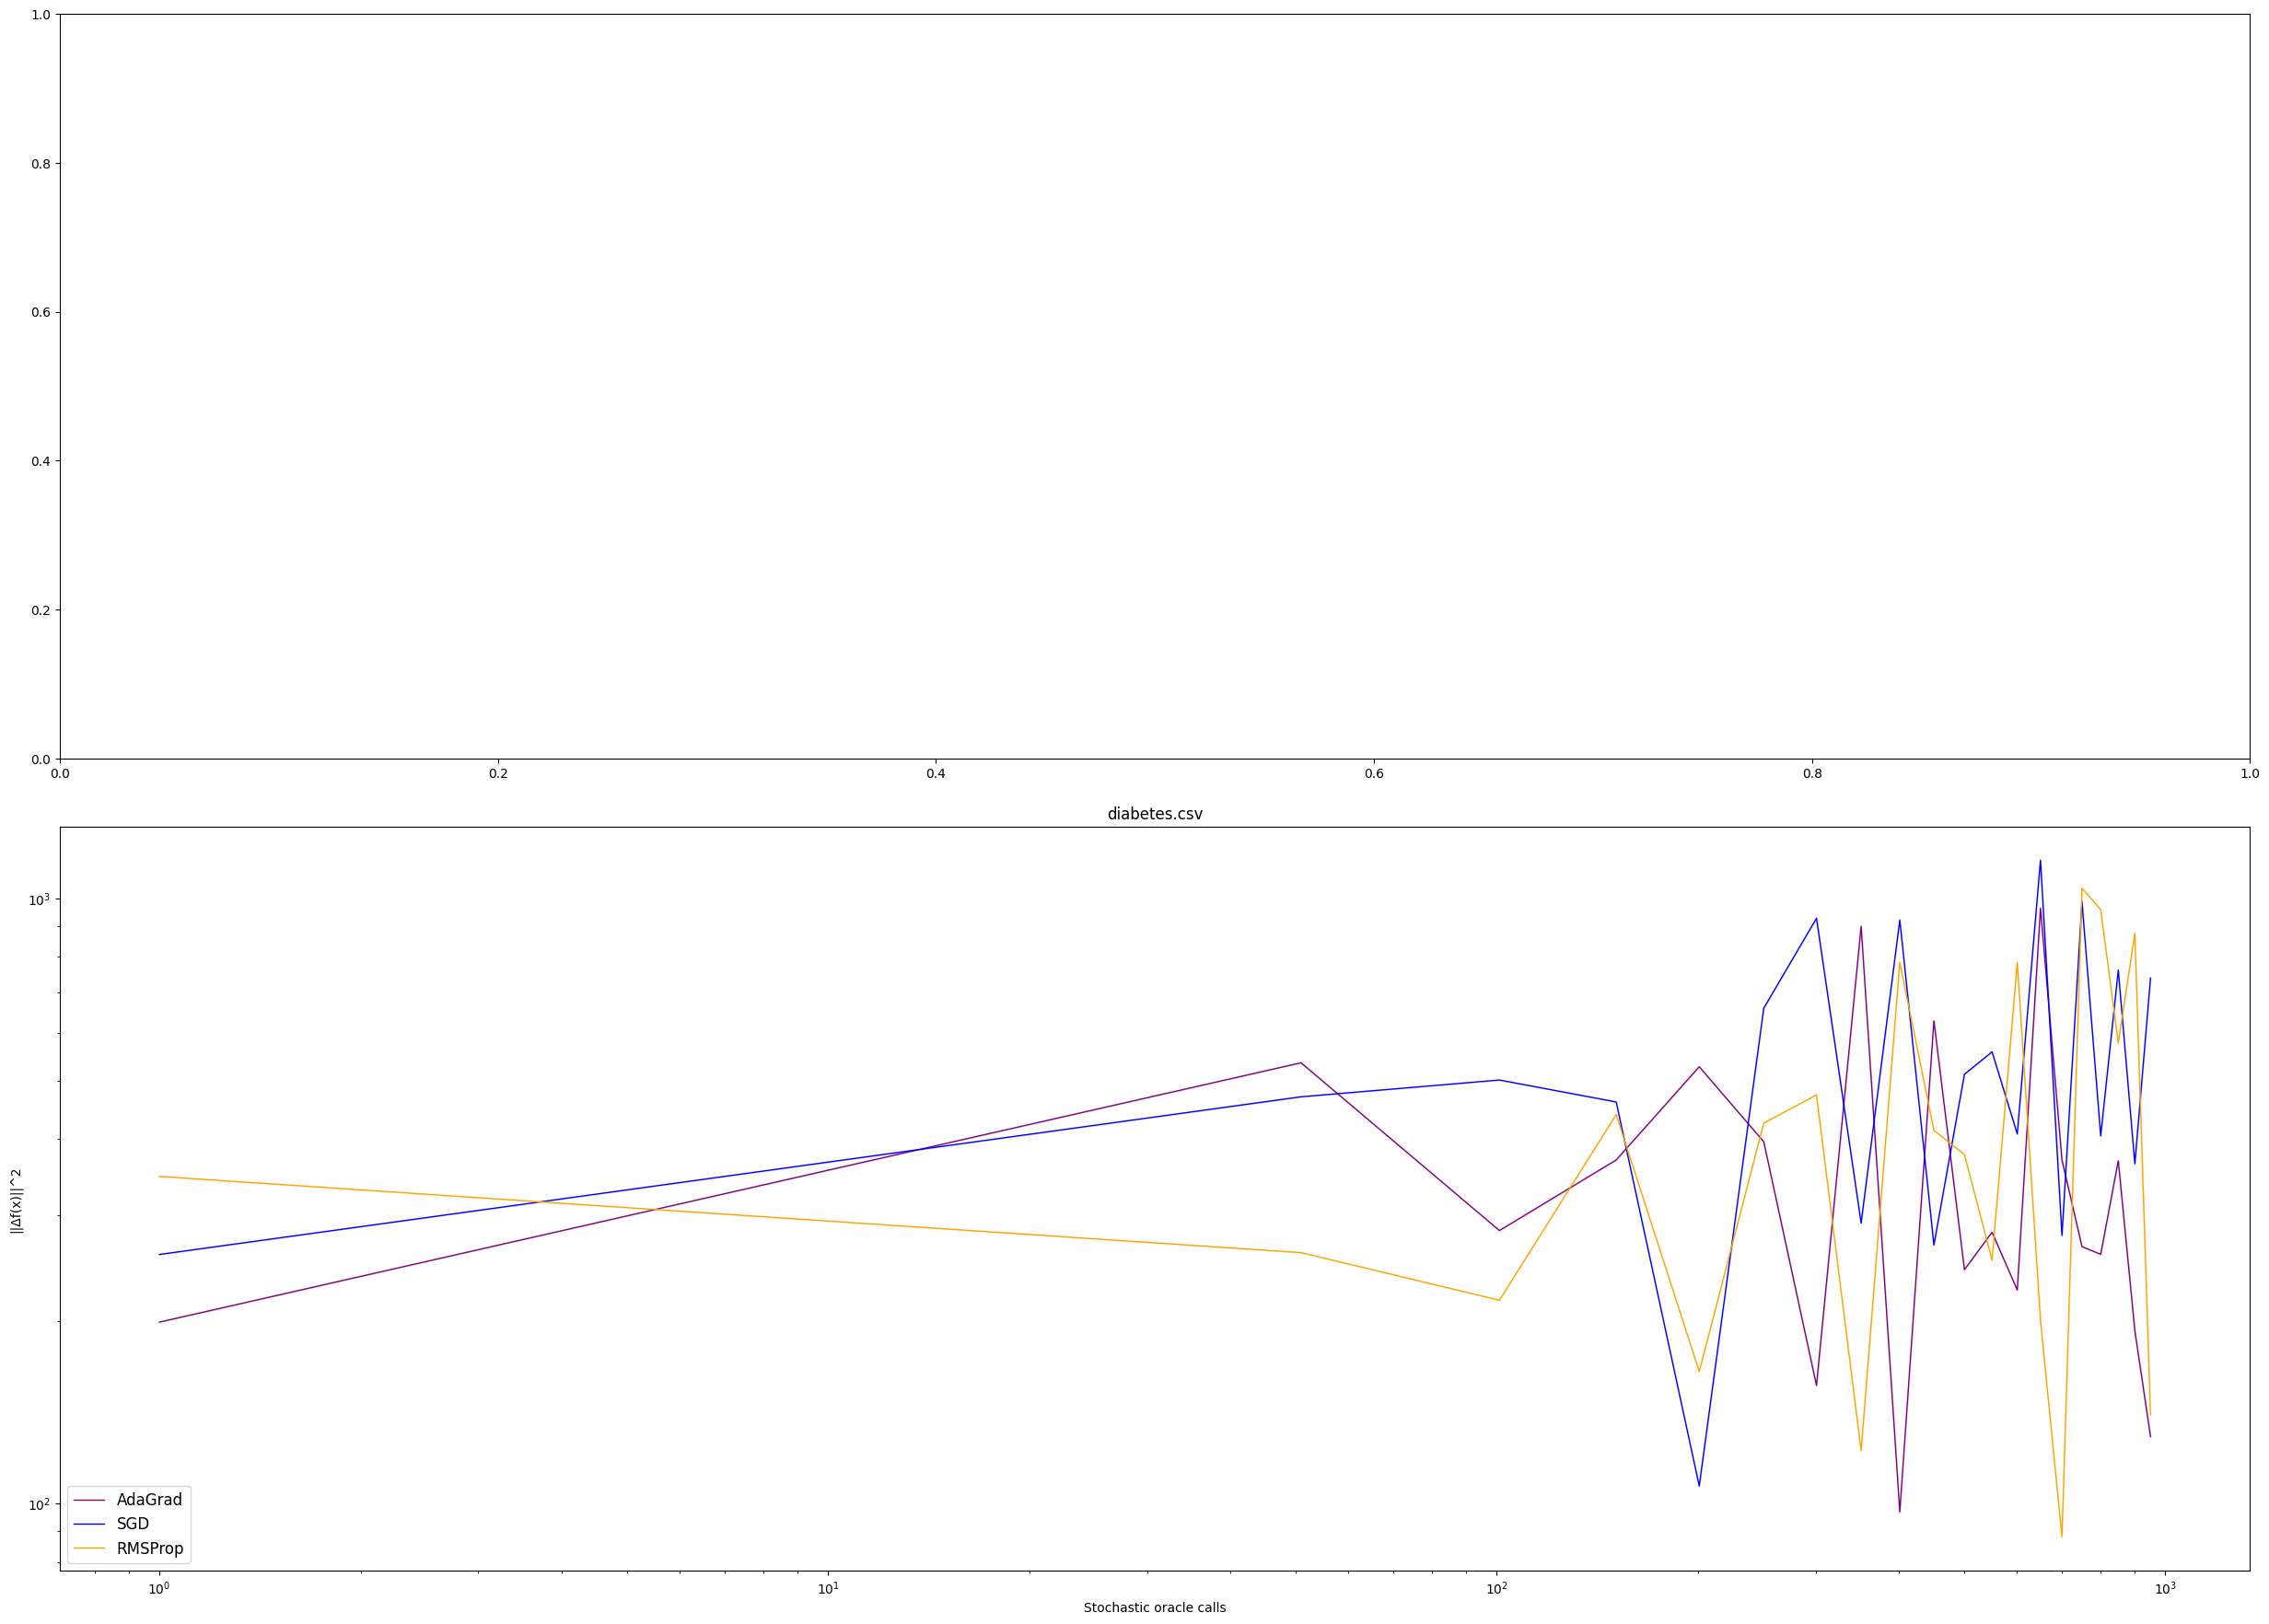

In [59]:
X_LABEL = "Stochastic oracle calls"
Y_LABEL = "||\u0394f(x)||^2"

fig, ax = plt.subplots(2, 1, figsize=(25, 18), sharey=False, sharex=False)

for dataset_name, dataset_data  in datasets_data.items():
    print("Dataset", dataset_name)

    sbplt = ax[i%2]

    for method_name, method_data in dataset_data.items():
        print("Method", method_name)

        method_color = methods_colors[method_name]
        gradients_mean = method_data['gradient_mean']
        lower = method_data['gradient_lower']
        upper = method_data['gradient_upper']

        n_iterations = method_data['n_iterations']

        EACH = 50
        gradients_mean = gradients_mean[0::EACH]
        lower = lower[0::EACH]
        upper = upper[0::EACH]

        grad_x = [(EACH*n)+1 for n in range(len(gradients_mean))]

        sbplt.plot(grad_x, gradients_mean, label=method_name,
                   linewidth=1, color=method_color)

        sbplt.fill_between(grad_x, lower, upper, alpha=0.12,
                           facecolor=method_color, edgecolor=method_color)

    sbplt.set_xscale('log')
    sbplt.set_yscale('log')
    sbplt.set_title(dataset_name)
    sbplt.set_xlabel(X_LABEL)
    sbplt.set_ylabel(Y_LABEL)
    sbplt.legend(loc='lower left', fontsize='large')
    break

fig.tight_layout(pad=2.0)

In [60]:
# for key, val in datasets_data['diabetes.csv'].items():
#     datasets_data['diabetes.csv'][key]['gradient_mean'] = list(val['gradient_mean'])
#     #datasets_data['a1a'][key]['lower'] = list(val['lower'])
#     #datasets_data['a1a'][key]['upper'] = list(val['upper'])

In [61]:
datasets_data

{'diabetes.csv': {'AdaGrad': {'gradient_mean': [199.44184702590715,
    280.6467495678739,
    138.88634133018317,
    1542.2613419625977,
    588.6159669104896,
    253.21590741599252,
    515.7690650566292,
    138.88772880389283,
    136.3747603856409,
    241.47488626597368,
    139.8549647519106,
    314.2481177886528,
    385.29308538091885,
    541.4692418818024,
    1005.3308865876875,
    607.9053477024694,
    523.824398694927,
    451.5279243408658,
    788.1468042194764,
    479.175394885412,
    521.8273939418444,
    770.4690591182449,
    691.327805973605,
    187.9403284670838,
    467.3110060377538,
    625.6724933612775,
    391.61454019673977,
    216.15788045292152,
    534.9246292841441,
    424.16095255338735,
    996.1215755335669,
    257.99399806740524,
    104.91999474479054,
    512.1477725537626,
    200.68979837540414,
    635.0204510139093,
    393.8431220811931,
    251.76572190676984,
    470.65557519281634,
    206.69208645639952,
    302.8422903541545,

In [62]:
with open('parameters_sweep_4.json', 'w') as file:
    json.dump(datasets_data, file)

In [ ]:
# get the mean length of gradients
print("DONE")
min_length = None
for key, val in datasets_data['a1a'].items():
    current_length = len(val['gradient_mean'])
    if min_length is None:
        min_length = current_length
    elif min_length > current_length:
        min_length = current_length
min_length

### Plot

In [ ]:
X_LABEL = "Stochastic oracle calls"
Y_LABEL = "||\u0394f(x)||^2"

fig, ax = plt.subplots(1, 1, figsize=(25, 18), sharey=False, sharex=False)  # 3, 2

for i, dataset_name in enumerate(DATASETS):
    print("Dataset", dataset_name)

    methods_data = datasets_data[dataset_name]

    sbplt = ax

    for method_name, method_data in methods_data.items():
        print("Method", method_name)

        gradients_mean = method_data['gradient_mean']
        lower = method_data['lower']
        upper = method_data['upper']
        n_iterations = method_data['n_iterations']

        sbplt.plot(gradients_mean[:min_length], label=method_name)
        sbplt.fill_between(list(range(len(gradients_mean[:min_length]))), lower[:min_length], upper[:min_length], alpha=0.25,
                           facecolor='red', edgecolor='red')

    sbplt.set_xscale('log')
    sbplt.set_yscale('log')
    sbplt.set_title(dataset_name)
    sbplt.set_xlabel(X_LABEL)
    sbplt.set_ylabel(Y_LABEL)
    sbplt.legend(loc='lower left', fontsize='large')

    break  # plot single dataset

fig.tight_layout(pad=2.0)
# fig.savefig(f'tests_logistic_regression_zeros_parameters_sweep_1_fixed_methods.jpg', dpi=300)

# plot_data()